## Part 3 - Consume/Transform data with Spark Streaming

In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StringType, StructField, IntegerType, FloatType, BinaryType
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
spark.version

'3.1.1'

In [4]:
spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()

'3.2.0'

## Raw Data Streams

In [5]:
def generate_stocktrades_stream():
    # Define the Spark Stream
    stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "latest") \
  .option("subscribe", "STOCKTRADES_JSON") \
  .load()
    # Convert to string types
    string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
      .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema
    schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
         StructField("USERID", StringType(), True)
])
    # Convert the string type to json
    # make json_stream_df global var
    global json_stream_df
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    ### Output is stored in memory as an in-memory table
    return stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrades_view") \
    .start()

### **Visualisation**

In [6]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline
from pyspark.sql.functions import desc

In [ ]:
def visualise():
    generate_stocktrades_stream()
    count = 0
    while count < 10:

        time.sleep(5)
        top_10_users = spark.sql('Select userid,sum(quantity) as quantity from stocktrades_view group by userid order by quantity desc limit 10' 
    )
        top_10_df = top_10_users.toPandas()
        display.clear_output(wait=True)
        plt.figure( figsize = ( 10, 8 ) )
        sns.barplot( x="quantity", y="userid", data=top_10_df)
        plt.show()
        count = count + 1
        print(f'Count:{count}')   

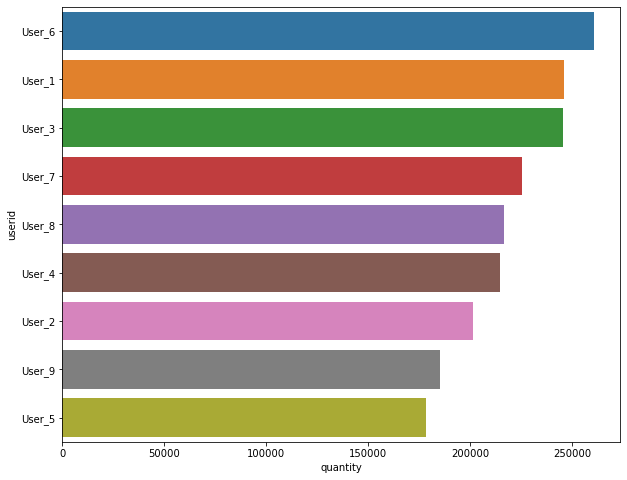

Count:6


In [ ]:
visualise()